/tmp/ipykernel_1738/2716913616.py:48: RuntimeWarning: Mean of empty slice.
  centroids[i] = X[self.labels == i].mean(axis=0)
/home/codespace/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


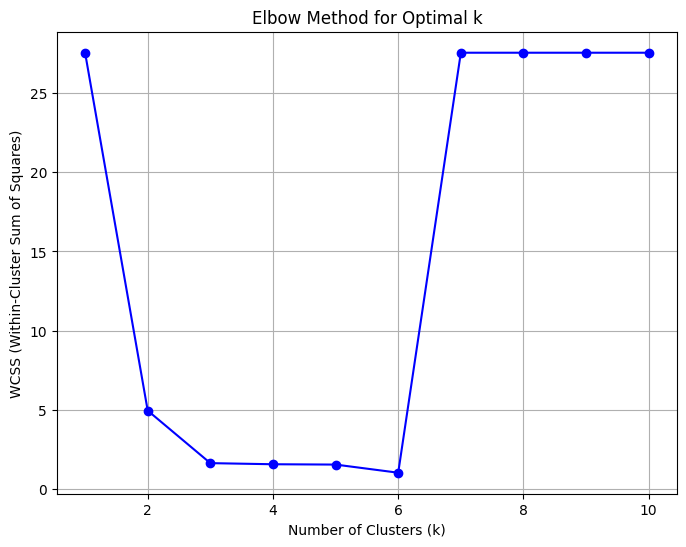

Optimal number of clusters: 2
Silhouette Score: 0.7433299410146433
Test Data (Actual values and predicted clusters):
Data point [0.62711864 0.45833333] | Actual Cluster: 1 | Predicted Cluster: 1
Data point [0.11864407 0.08333333] | Actual Cluster: 0 | Predicted Cluster: 0
Data point [1.         0.91666667] | Actual Cluster: 2 | Predicted Cluster: 1
Data point [0.59322034 0.58333333] | Actual Cluster: 1 | Predicted Cluster: 1


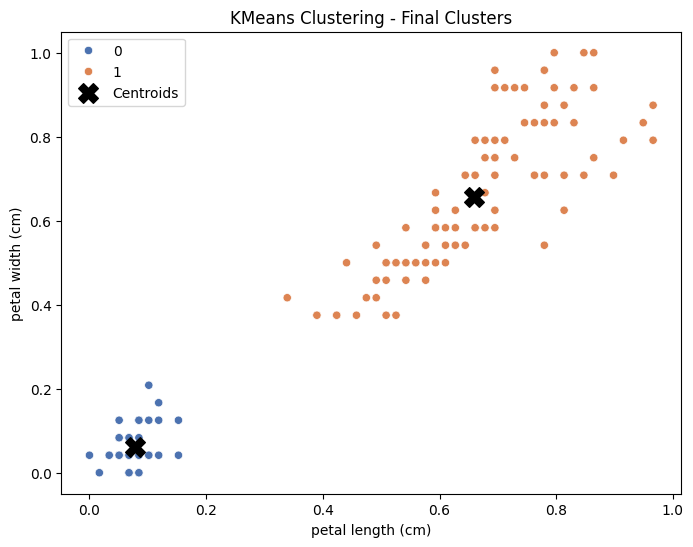

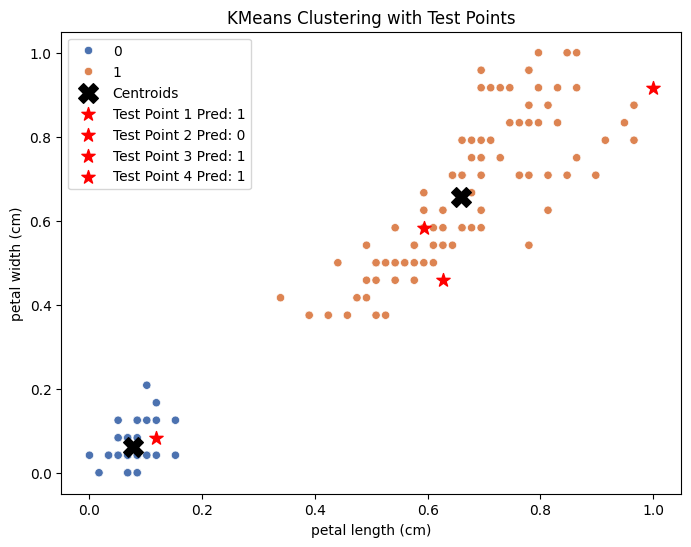

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import pandas as pd

# 1. Implement KMeans from Scratch
class KMeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        # Set the random seed for reproducibility
        if self.random_state:
            np.random.seed(self.random_state)      

        # Initialize centroids randomly from the data points
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            # Step 1: Assign labels (clusters) based on closest centroid
            self.labels = self.assign_labels(X)

            # Step 2: Calculate new centroids based on the mean of points assigned to each cluster
            new_centroids = self.compute_centroids(X)

            # Step 3: Check for convergence (if centroids do not change)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break

            self.centroids = new_centroids

    def assign_labels(self, X):
        # Compute Euclidean distance between each point and each centroid
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def compute_centroids(self, X):
        # Compute the mean of all points in each cluster
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            centroids[i] = X[self.labels == i].mean(axis=0)
        return centroids

    def predict(self, X):
        return self.assign_labels(X)

# 2. Load the iris dataset and select only the petal length and petal width features
iris = load_iris()
X = iris.data[:, 2:4]  # Select petal length and petal width

# 3. Remove outliers using IQR (Interquartile Range)
def remove_outliers(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((X >= lower_bound) & (X <= upper_bound), X, np.nan)

# Remove outliers
X_no_outliers = remove_outliers(X)
X_no_outliers = X_no_outliers[~np.isnan(X_no_outliers).any(axis=1)]  # Remove rows with NaN values

# 4. Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_no_outliers)

# 5. Select 4 data points for testing (Randomly select 4 indices)
np.random.seed(42)
test_indices = np.random.choice(X_scaled.shape[0], 4, replace=False)

# Separate the test data from the training data
X_train = np.delete(X_scaled, test_indices, axis=0)
X_test = X_scaled[test_indices]
y_test = iris.target[test_indices]

# 6. Determine the optimal number of clusters using the Elbow Method
# wcss = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_train)
#     wcss.append(np.sum((X_train - kmeans.centroids[kmeans.labels]) ** 2))

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    
    # Calculate squared differences for all data points
    squared_diff = (X_train - kmeans.centroids[kmeans.labels]) ** 2
    
    # Sum squared differences for each data point
    sum_squared_diff = np.sum(squared_diff, axis=0)
    
    # Sum up the sum of squared differences for all data points to get WCSS
    wcss.append(np.sum(sum_squared_diff))

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# 7. Automatically determine the optimal k (Elbow method)
# Find the "elbow" point by looking for the largest difference in WCSS values
diff = np.diff(wcss)
optimal_k = np.argmin(diff) + 2  # +2 because the diff array has one less element than the wcss array

print(f"Optimal number of clusters: {optimal_k}")

# 8. Perform KMeans with the optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_train)

# 9. Get the cluster labels and Silhouette Score
cluster_labels = kmeans_final.labels
silhouette_avg = silhouette_score(X_train, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# 10. Predict the clusters for the test data
test_predictions = kmeans_final.predict(X_test)

# 11. Print the actual values and their predicted cluster labels
print("Test Data (Actual values and predicted clusters):")
for i in range(len(test_predictions)):
    print(f"Data point {X_test[i]} | Actual Cluster: {y_test[i]} | Predicted Cluster: {test_predictions[i]}")

# 12. Visualize the clusters
def plot_clusters(X, cluster_labels, centroids, iris_feature_names, dataset_type="Dataset"):
    df_scaled = pd.DataFrame(X, columns=iris_feature_names)
    df_scaled['Cluster'] = cluster_labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_scaled, x=iris_feature_names[0], y=iris_feature_names[1], hue='Cluster', palette='deep', legend="full")
    
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=200, marker='X', label='Centroids')

    plt.title(f'KMeans Clustering - {dataset_type}')
    plt.xlabel(iris_feature_names[0])
    plt.ylabel(iris_feature_names[1])
    plt.legend()
    plt.show()

# Plot the final clusters
plot_clusters(X_train, cluster_labels, kmeans_final.centroids, iris.feature_names[2:], dataset_type="Final Clusters")

# 13. Plot the test data points on top of the cluster plot
def plot_with_test_points(X, X_test, test_predictions, cluster_labels, centroids, iris_feature_names):
    df_scaled = pd.DataFrame(X, columns=iris_feature_names)
    df_scaled['Cluster'] = cluster_labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_scaled, x=iris_feature_names[0], y=iris_feature_names[1], hue='Cluster', palette='deep', legend="full")
    
    # Plot the centroids
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=200, marker='X', label='Centroids')

    # Plot the test data points with a different marker and color
    for i in range(len(X_test)):
        plt.scatter(X_test[i][0], X_test[i][1], color='red', s=100, marker='*', label=f'Test Point {i+1} Pred: {test_predictions[i]}')

    plt.title(f'KMeans Clustering with Test Points')
    plt.xlabel(iris_feature_names[0])
    plt.ylabel(iris_feature_names[1])
    plt.legend()
    plt.show()

# Plot the clusters with the test points marked
plot_with_test_points(X_train, X_test, test_predictions, cluster_labels, kmeans_final.centroids, iris.feature_names[2:])


In [2]:
import numpy as np
X = np.array([[2, 1],  # Point 1
              [2, 3],  # Point 2
              [4, 3]]) # Point 3
X.shape

(3, 2)